## Task 1 - Zero-Shot Evaluation

In [7]:
#@title GPU / Python / Torch sanity
import os, sys, subprocess, json, platform, torch
print("Python :", sys.version)
print("CUDA   :", torch.version.cuda)
print("Torch  :", torch.__version__)
print("Device :", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")
!nvidia-smi || true

Python : 3.10.19 (main, Oct 21 2025, 16:43:05) [GCC 11.2.0]
CUDA   : 12.1
Torch  : 2.5.1+cu121
Device : NVIDIA GeForce RTX 4090
Mon Nov 10 23:13:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        Off |   00000000:01:00.0 Off |                  Off |
| 35%   62C    P2            301W /  450W |   18850MiB /  24564MiB |     93%      Default |
|           

In [8]:
# some imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from transformers import CLIPProcessor, CLIPModel, CLIPVisionModel, logging
from peft import LoraConfig, get_peft_model, TaskType
from torchinfo import summary
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import json
import warnings
# =====Modified======
import pandas as pd 

In [9]:
# some settings
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_ID = "openai/clip-vit-large-patch14" # pre-trained CLIP model (ViT-L/14)
BATCH_SIZE = 1 # adjust based on your GPU memory
gradient_accumulation_steps = 1 # adjust based on your GPU memory
# For Linear Probe & LoRA
NUM_EPOCHS = 1
print(f"Using device: {DEVICE}")

Using device: cuda


In [10]:
# CLIP settings
# --- Load CLIP Processor ---
processor = CLIPProcessor.from_pretrained(MODEL_ID)
# --- Define a transform to process images for CLIP ---
class CLIPTransform:
    def __init__(self, processor):
        self.processor = processor

    def __call__(self, image):
        # The processor expects a PIL image or list of images
        # It returns a dict, we extract 'pixel_values'
        # .squeeze(0) removes the batch dimension the processor adds
        return self.processor(images=image, return_tensors="pt")["pixel_values"].squeeze(0)

clip_transform = CLIPTransform(processor)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
# dataset related imports
from torchvision.datasets import Flowers102 
from datasets import load_dataset

# --- Flowers102 ---
# prepare Flowers102 dataset

# transform: object => clip_transform
flowers102_test_dts = Flowers102(root="", split="test", transform=clip_transform, download=True ) # evaluation on this set
print(f"Total test samples: {len(flowers102_test_dts)}") # should be 6149

# prepare class names for Flowers102
# =========Modified==========
# load Flowers102 cat
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
flowers102_class_names = [cat_to_name[str(i)] for i in range(1, 103)]
print(f"Loaded {len(flowers102_class_names)} class names for Flowers102.")

# --- CUB-200-2011 ---
birds_200 = load_dataset("bentrevett/caltech-ucsd-birds-200-2011")
cub_bird_test_dts = birds_200["test"]
print(f"Total test samples: {len(cub_bird_test_dts)}") # should be 5794

# prepare class names for CUB-200-2011
# ========modified=======
cub_class_names = birds_200["test"].features['label'].names
# ('001."Black_footed_Albatross"')
cub_class_names = [name.split('.')[-1].replace('_', ' ') for name in cub_class_names]
print(f"Loaded {len(cub_class_names)} class names for CUB-200-2011.")

# =======Modified================
# 4. CUB-200 dataset add transform
#    use set_transform to process HuggingFace datasets 
def cub_transform(examples):
    # transform PIL img and use CLIP processor
    examples['pixel_values'] = [clip_transform(image.convert("RGB")) for image in examples['image']]
    return examples
cub_bird_test_dts.set_transform(cub_transform)

# === Create DataLoaders ===
from torch.utils.data import DataLoader

flowers102_test_loader = DataLoader(
    dataset=flowers102_test_dts,
    batch_size=BATCH_SIZE,
    shuffle=False
)

cub_bird_test_loader = DataLoader(
    dataset=cub_bird_test_dts,
    batch_size=BATCH_SIZE,
    shuffle=False,
    # collate_fn will packed batches, take only pixel_values and label
    collate_fn=lambda batch_list: {
        'pixel_values': torch.stack([item['pixel_values'] for item in batch_list]),
        'label': torch.tensor([item['label'] for item in batch_list])
    }
)

print("DataLoaders created.")

Total test samples: 6149
Loaded 102 class names for Flowers102.
Total test samples: 5794
Loaded 200 class names for CUB-200-2011.
DataLoaders created.


In [ ]:
print("--- Starting Method 1: Zero-Shot Classification ---")

from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import random

# === 1. Load the full CLIP model ===
model = CLIPModel.from_pretrained(MODEL_ID).to(DEVICE)
print(f"CLIP model {MODEL_ID} loaded to {DEVICE}.")

# === 2. Create and encode text prompts ===

def encode_prompts(prompts):
    """prompt => text features"""
    inputs = processor(text=prompts, return_tensors="pt", padding=True, truncation=True).to(DEVICE)
    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
    # normalized features
    text_features /= text_features.norm(dim=-1, keepdim=True)
    return text_features

# --- 2a.Default Prompt ---
default_template = "A photo of a {label}."
flowers_prompts_default = [default_template.format(label=name) for name in flowers102_class_names]
cub_prompts_default = [default_template.format(label=name) for name in cub_class_names]

flowers_text_features_default = encode_prompts(flowers_prompts_default)
cub_text_features_default = encode_prompts(cub_prompts_default)
print(f"Encoded {len(flowers_prompts_default)} default prompts for Flowers.")
print(f"Encoded {len(cub_prompts_default)} default prompts for CUB.")

# --- 2b.Custom Prompt ---
custom_template_flower = "a high-resolution photo of a {label}, which is a species of flower."
custom_template_bird = "a high-resolution photo of a {label}, which is a species of bird."

flowers_prompts_custom = [custom_template_flower.format(label=name) for name in flowers102_class_names]
cub_prompts_custom = [custom_template_bird.format(label=name) for name in cub_class_names]

flowers_text_features_custom = encode_prompts(flowers_prompts_custom)
cub_text_features_custom = encode_prompts(cub_prompts_custom)
print(f"Encoded {len(flowers_prompts_custom)} custom prompts for Flowers.")
print(f"Encoded {len(cub_prompts_custom)} custom prompts for CUB.")


# === 3. Evaluate on the test set ===
def evaluate_zero_shot(loader, text_features):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(loader, desc="Zero-Shot Evaluation"):
            # batch(list 或 dict)
            if isinstance(batch, dict):
                # CUB loader : {'pixel_values': ..., 'label': ...}
                images = batch['pixel_values'].to(DEVICE)
                labels = batch['label'].to(DEVICE)
            elif isinstance(batch, list) and len(batch) == 2:
                # Flowers102 loader : [images, labels]
                images, labels = batch
                images = images.to(DEVICE)
                labels = labels.to(DEVICE)
            else:
                raise ValueError("DataLoader 產生的 batch 格式無法識別。")

            # 1. get image features
            image_features = model.get_image_features(pixel_values=images)
            image_features /= image_features.norm(dim=-1, keepdim=True)

            # 2.logits
            # (100.0 * image_features @ text_features.T)
            logits_per_image = model.logit_scale.exp() * image_features @ text_features.T
            
            # 3.final result
            preds = logits_per_image.argmax(dim=-1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    return all_labels, all_preds

# ---Evaluate (Default) ---
flowers_labels_def, flowers_preds_def = evaluate_zero_shot(flowers102_test_loader, flowers_text_features_default)
cub_labels_def, cub_preds_def = evaluate_zero_shot(cub_bird_test_loader, cub_text_features_default)

# ---Evaluate (Custom) ---
flowers_labels_cus, flowers_preds_cus = evaluate_zero_shot(flowers102_test_loader, flowers_text_features_custom)
cub_labels_cus, cub_preds_cus = evaluate_zero_shot(cub_bird_test_loader, cub_text_features_custom)
    

--- Starting Method 1: Zero-Shot Classification ---
CLIP model openai/clip-vit-large-patch14 loaded to cuda.
Encoded 102 default prompts for Flowers.
Encoded 200 default prompts for CUB.
Encoded 102 custom prompts for Flowers.
Encoded 200 custom prompts for CUB.


Zero-Shot Evaluation:   0%|          | 0/6149 [00:00<?, ?it/s]

Zero-Shot Evaluation:   0%|          | 0/5794 [00:00<?, ?it/s]

Zero-Shot Evaluation:   0%|          | 0/6149 [00:00<?, ?it/s]

Zero-Shot Evaluation:   0%|          | 0/5794 [00:00<?, ?it/s]


--- 4a. Prompt Comparison Table ---
| Dataset            | Default Prompt Acc.   | Custom Prompt Acc.   |
|:-------------------|:----------------------|:---------------------|
| Oxford 102 Flowers | 74.74%                | 78.32%               |
| CUB-200-2011       | 62.32%                | 62.53%               |

--- 4b. Classification Report (Flowers102 - Default Prompt) ---
                           precision    recall  f1-score   support

            pink primrose       0.38      0.95      0.54        20
hard-leaved pocket orchid       0.91      0.75      0.82        40
         canterbury bells       0.36      0.75      0.48        20
                sweet pea       1.00      0.92      0.96        36
         english marigold       0.37      0.42      0.40        45
               tiger lily       0.81      1.00      0.89        25
              moon orchid       0.67      1.00      0.80        20
         bird of paradise       1.00      1.00      1.00        65
              

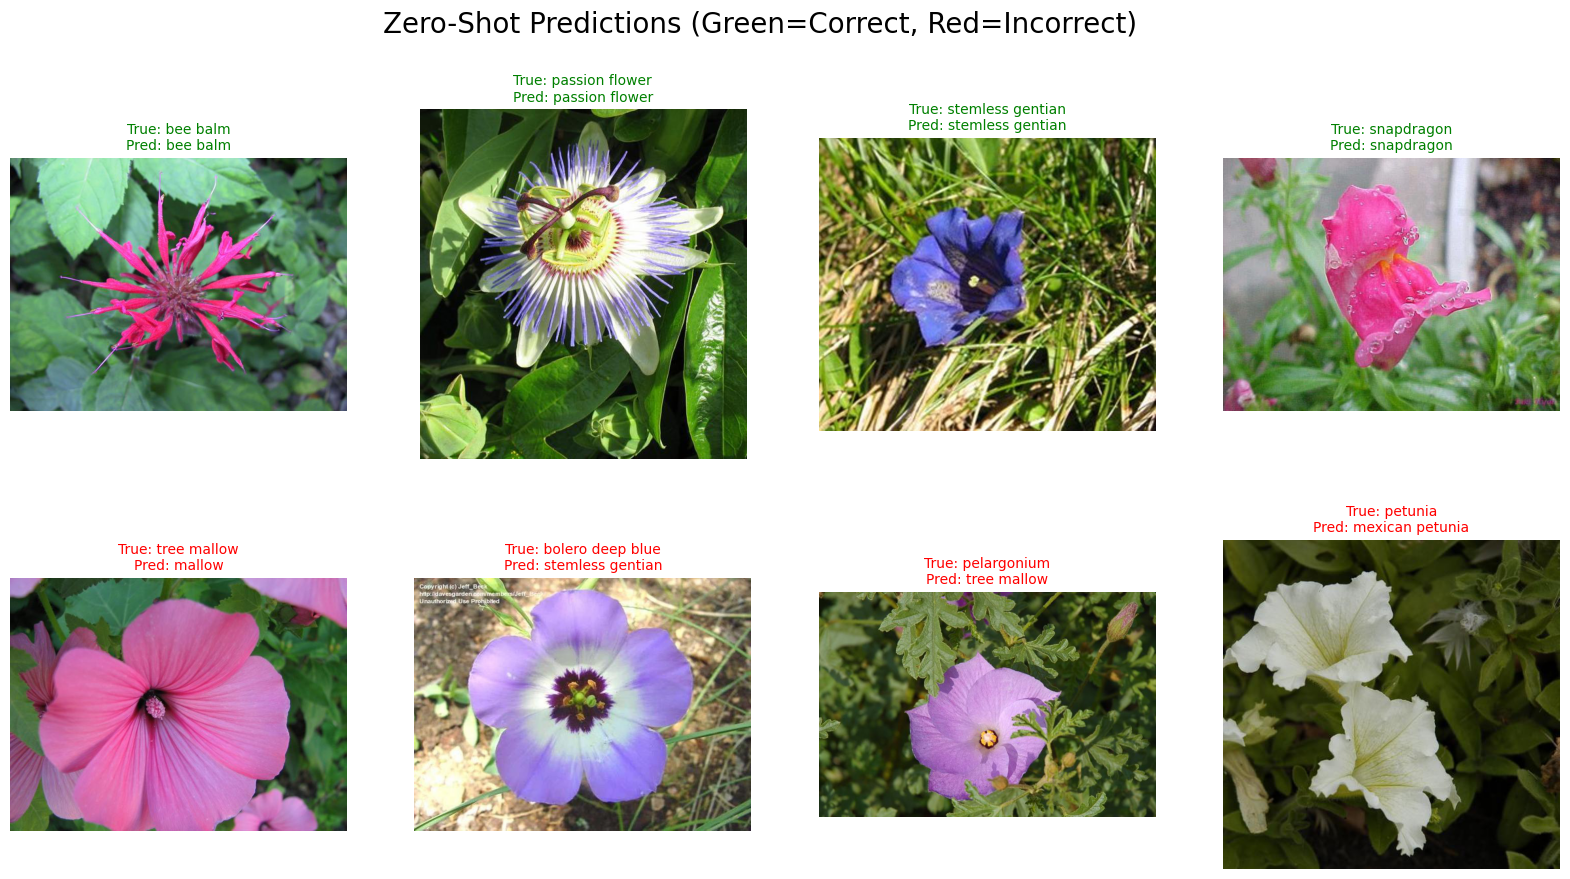

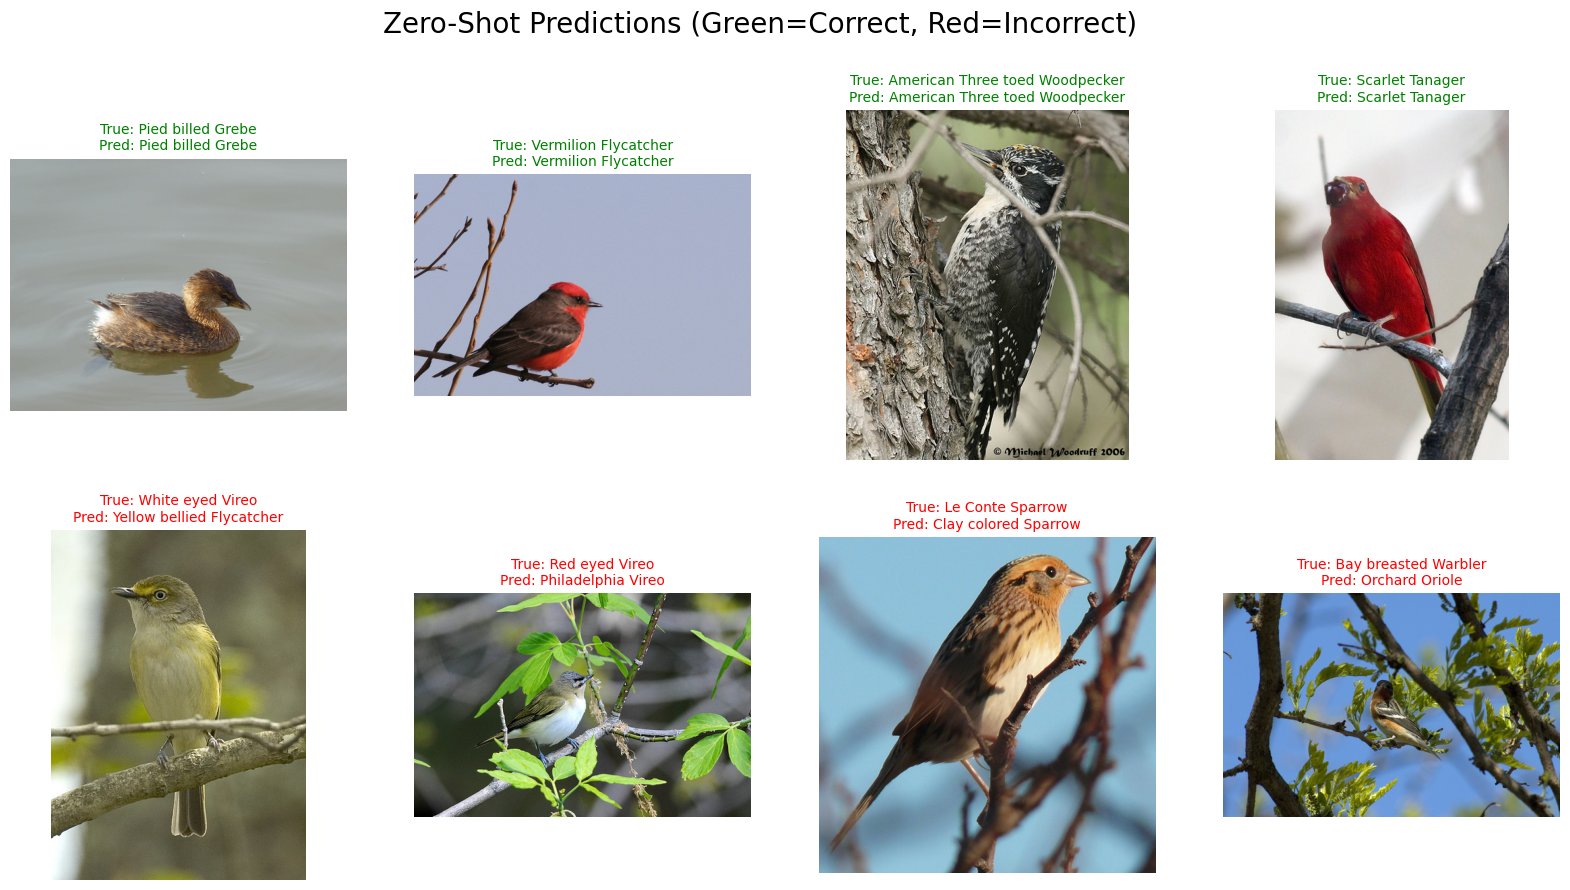

In [ ]:
# === 4. Result Analysis ===

flowers102_accuracy_def = accuracy_score(flowers_labels_def, flowers_preds_def)
cub_bird_accuracy_def = accuracy_score(cub_labels_def, cub_preds_def)
flowers102_accuracy_cus = accuracy_score(flowers_labels_cus, flowers_preds_cus)
cub_bird_accuracy_cus = accuracy_score(cub_labels_cus, cub_preds_cus)

table_data = {
    "Dataset": ["Oxford 102 Flowers", "CUB-200-2011"],
    "Default Prompt Acc.": [f"{flowers102_accuracy_def*100:.2f}%", f"{cub_bird_accuracy_def*100:.2f}%"],
    "Custom Prompt Acc.": [f"{flowers102_accuracy_cus*100:.2f}%", f"{cub_bird_accuracy_cus*100:.2f}%"]
}
df = pd.DataFrame(table_data)
print("\n--- 4a. Prompt Comparison Table ---")
print(df.to_markdown(index=False))

print("\n--- 4b. Classification Report (Flowers102 - Default Prompt) ---")
print(classification_report(flowers_labels_def, flowers_preds_def, target_names=flowers102_class_names, zero_division=0))

print("\n--- 4c. Classification Report (CUB-200 - Default Prompt) ---")
print(classification_report(cub_labels_def, cub_preds_def, target_names=cub_class_names, zero_division=0))


# === 5. Visualization ===
def visualize_predictions(dataset, class_names, all_labels, all_preds):
    is_flowers = isinstance(dataset.dataset, Flowers102)
    
    if is_flowers:
        dset_viz = Flowers102(root="", split="test", transform=None, download=True)
        get_item = lambda i: dset_viz[i] # (img, label)
    else:
        dset_viz = load_dataset("bentrevett/caltech-ucsd-birds-200-2011")["test"]
        get_item = lambda i: (dset_viz[i]['image'], dset_viz[i]['label']) # (img, label)

    plt.figure(figsize=(20, 10))
    
    correct_indices = [i for i, (l, p) in enumerate(zip(all_labels, all_preds)) if l == p]
    incorrect_indices = [i for i, (l, p) in enumerate(zip(all_labels, all_preds)) if l != p]
    
    # ensure the amount of samples are enough
    import random
    viz_indices = random.sample(correct_indices, min(4, len(correct_indices))) + \
                  random.sample(incorrect_indices, min(4, len(incorrect_indices)))
    
    plt.suptitle("Zero-Shot Predictions (Green=Correct, Red=Incorrect)", fontsize=20)
    for i, idx in enumerate(viz_indices):
        img, label = get_item(idx)
        pred_label = all_preds[idx]
        color = "green" if label == pred_label else "red"
        
        plt.subplot(2, 4, i + 1)
        plt.imshow(img)
        plt.title(f"True: {class_names[label]}\nPred: {class_names[pred_label]}", color=color, fontsize=10)
        plt.axis("off")
    
    # store img
    # plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    # plt.show()
    plt.savefig(f"zeroshot_examples_{'flowers' if is_flowers else 'cub'}.png")
    print(f"Saved visualization to zeroshot_examples_{'flowers' if is_flowers else 'cub'}.png")

# Visualize
print("\n--- 5a. Visualization (Flowers102 - Default Prompt) ---")
visualize_predictions(flowers102_test_loader, flowers102_class_names, flowers_labels_def, flowers_preds_def)
print("\n--- 5b. Visualization (CUB-200 - Default Prompt) ---")
visualize_predictions(cub_bird_test_loader, cub_class_names, cub_labels_def, cub_preds_def)

成功載入並處理照片: my_ntu_bird.jpg

--- 預測頂端結果 ---
Zero-Shot Pred: Bronzed Cowbird

[成功] Zero-Shot 比較圖表已儲存為 'ntu_bird_test_zeroshot.png'


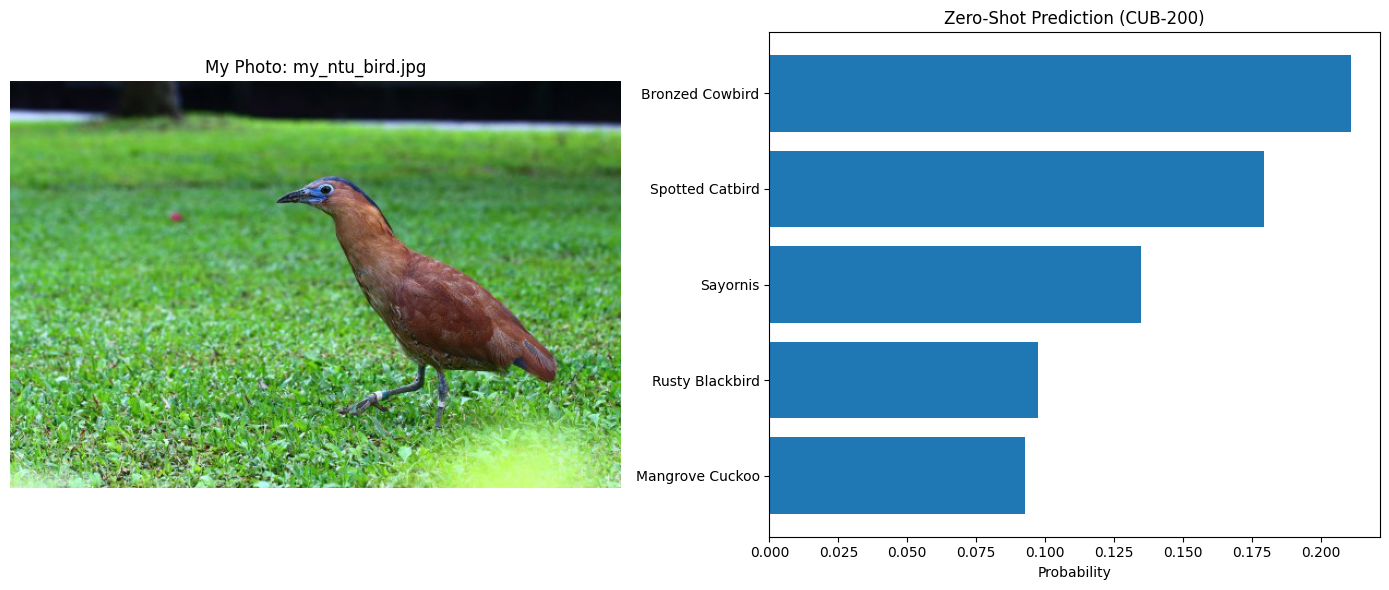

In [ ]:
import PIL.Image
import torch
import matplotlib.pyplot as plt

# === 1. YOUR_PHOTO_FILENAME ===
YOUR_PHOTO_FILENAME = "my_ntu_bird.jpg" 

# === 2. Load and Preprocess ===
try:
    image_pil = PIL.Image.open(YOUR_PHOTO_FILENAME).convert("RGB")
    image_transformed = clip_transform(image_pil) 
    image_tensor = image_transformed.unsqueeze(0).to(DEVICE)

    print(f"成功載入並處理照片: {YOUR_PHOTO_FILENAME}")
except FileNotFoundError:
    print(f"錯誤：找不到照片 '{YOUR_PHOTO_FILENAME}'。請檢查檔名並確認已上傳。")
    raise

# === 3. Get CUB-200 cat and Text Features ===
# cub_class_names
# cub_text_features_default

# === 4.Zero-Shot ===
# use model pretrained before this cell
model.eval()
with torch.no_grad():
    # 1. get image features
    image_features = model.get_image_features(pixel_values=image_tensor)
    image_features /= image_features.norm(dim=-1, keepdim=True)


    logits_per_image = model.logit_scale.exp() * image_features @ cub_text_features_default.T
    
    probs = logits_per_image.softmax(dim=-1)

# === 5.Visualize Top 5 predict result ===
def plot_top5(ax, probs, class_names, title):
    """在指定的 ax 上繪製 Top 5 機率的水平長條圖"""
    top5_probs, top5_indices = torch.topk(probs.squeeze(), 5)
    
    top5_probs = top5_probs.cpu().numpy()
    top5_indices = top5_indices.cpu().numpy()
    
    top5_names = [class_names[i] for i in top5_indices]
    
    # plot
    bars = ax.barh(top5_names, top5_probs)
    ax.invert_yaxis()
    ax.set_title(title)
    ax.set_xlabel("Probability")
    
    return top5_names[0]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].imshow(image_pil)
axes[0].set_title(f"My Photo: {YOUR_PHOTO_FILENAME}")
axes[0].axis('off')

pred_zs = plot_top5(axes[1], probs, cub_class_names, "Zero-Shot Prediction (CUB-200)")

plt.tight_layout()
plt.savefig("ntu_bird_test_zeroshot.png")
print("\n--- 預測頂端結果 ---")
print(f"Zero-Shot Pred: {pred_zs}")
print("\n[成功] Zero-Shot 比較圖表已儲存為 'ntu_bird_test_zeroshot.png'")
plt.show()